**Name:** LIXINYAN

**EID:** 55670594

# CS5489 - Tutorial 10
## Using Deep Features

In this tutorial you will train a classifier to classify images with different types of cakes using deep features.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
import skimage.io
import skimage.transform

Second, initialize Keras and Tensorflow

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization, \
                                    GlobalAveragePooling2D, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import logging
logging.basicConfig()
import struct
print(keras.__version__, tf.__version__)
# use keras backend (K) to force channels-last ordering
K.set_image_data_format('channels_last')

2.7.0 2.7.0


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `cakes.zip`, and put it in the same direcotry as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [3]:
imgdata = []
classes = []

# load the zip file
filename = 'cakes.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "cakes/*/*.jpg"):
        
        # filename is : cakes/class/file.jpg
        (fdir1, fname)  = os.path.split(name)  # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class 

        # open file in memory, and parse as an image
        myfile = zfile.open(name)
        #img = matplotlib.image.imread(myfile)
        img = skimage.io.imread(myfile)
        img2 = skimage.transform.resize(img, (224,224), anti_aliasing=False)
        
        myfile.close()

        imgdata.append(img2)
        classes.append(fclass)
        
zfile.close()
print(len(imgdata))
print(img.size)

/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


800
589824


Each image is a 224x224. There are 8 classes of differerent cakes.  Run the below code to show examples of each class.

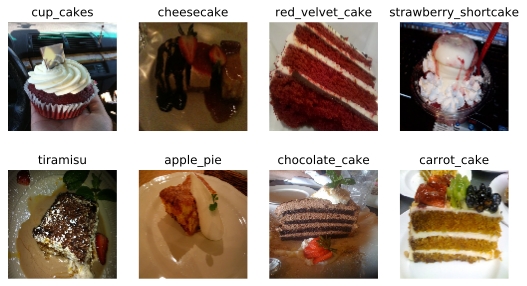

In [4]:
plt.figure(figsize=(9,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    ind = i*100
    plt.imshow(imgdata[ind])    
    plt.title(classes[ind])
    plt.axis('off')
plt.show()

Next, store the images into a Tensor. ResNet assumes the data is [0,255] range, so we need to scale the images that were read in with skimage.

In [5]:
Xraw = zeros((len(imgdata), 224, 224, 3))
for i,img in enumerate(imgdata):
    x = image.img_to_array(img)*255   # preprocessing expects range [0,255]
    x = expand_dims(x, axis=0)
    Xraw[i,:] = x

Finally, we convert the class label strings into class numbers.

In [6]:
# convert class strings into integers
print("class labels (strings):", unique(classes))
le = preprocessing.LabelEncoder()
Y = le.fit_transform(classes)
print("Converted labels:")
print(Y)
Yb = keras.utils.to_categorical(Y)

class labels (strings): ['apple_pie' 'carrot_cake' 'cheesecake' 'chocolate_cake' 'cup_cakes'
 'red_velvet_cake' 'strawberry_shortcake' 'tiramisu']
Converted labels:
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7
 7 7 7 7 7

## 2. Extract Deep features
Now preprocess the images in imdata and put them into a 4D tensor for ResNet.  Store it in a tensor `Xim`.  
Note that `preprocess_input` will overwrite its input data, so you may need to make a `copy` if you want to preserve `Xraw`.

In [7]:
### INSERT YOUR CODE HERE ###

In [8]:
# expand dim to 4D
import numpy as np
import tensorflow.keras.applications.resnet50 as resnet

# Xim=[]
Xim = zeros((len(imgdata), 224, 224, 3))

for i,img in enumerate(imgdata):
    xi = image.img_to_array(img)
    xi = expand_dims(xi, axis=0)
    xi = resnet.preprocess_input(xi)
    Xim[i,:] = xi
print(Xim.shape)

(800, 224, 224, 3)


Extract features from Resnet50, call it `Xf`.

In [9]:
### INSERT YOUR CODE HERE ###

In [10]:
model_f = resnet.ResNet50(weights='imagenet', 
                          include_top=False,  # remove the classification layer
                          pooling='avg')      # apply GlobalAveragePooling

# compute the features
Xf = model_f.predict(Xim)
print(Xf.shape)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(800, 2048)


## 3. Train a classifier
Split the data into training and testing for the classifier.

In [11]:
# randomly split data into train and test set
( trainXf, testXf,       # features 
  trainY, testY,         # class labels
  trainYb, testYb,       # class one-hot vectors
  trainXim, testXim,     # processed images
  trainXraw, testXraw,   # raw images
  trainimgdata, testimgdata,     # raw images
) = \
  model_selection.train_test_split(Xf, Y, Yb, Xim, Xraw, imgdata,
  train_size=0.8, test_size=0.2, random_state=4487)

print(trainXf.shape)
print(testXf.shape)
print(trainY.shape)
print(testY.shape)
print(trainXim.shape)

(640, 2048)
(160, 2048)
(640,)
(160,)
(640, 224, 224, 3)


Now train a few traditional classifier (e.g, SVM, logistic regression, random forest, etc.) and compute the accuracy.

In [12]:
### INSERT YOUR CODE HERE ###

### 1 - SVM classifier

In [13]:
# SVM
paramgrid = {'C': logspace(-3,3,13),
             'gamma': [1, 0.1, 0.01, 0.001],
             'kernel': ['rbf']}

svmpoly = model_selection.GridSearchCV(svm.SVC(), paramgrid, 
                                       cv=3, n_jobs=-1, verbose=True)
svmpoly.fit(trainXf, trainY)
predY = svmpoly.predict(testXf)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy = ", acc)

Fitting 3 folds for each of 52 candidates, totalling 156 fits
test accuracy =  0.2


### 2 - LR classifier

In [14]:
# Logistic Regression
paramgrid = {'C': np.logspace(-4,4,5),
             'penalty': ['l1', 'l2', 'elasticnet']}

lrcv = model_selection.GridSearchCV(linear_model.LogisticRegression(),
                                     paramgrid, cv=3, n_jobs=-1)

lrcv.fit(trainXf, trainY)
predY = lrcv.predict(testXf)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy=", acc)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.12969301        nan        nan 0.16248373        nan
        nan 0.22192971        nan        nan 0.22816755        nan
        nan 0.21723487        nan]
  category=UserWarning


test accuracy= 0.2125


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 3 - RF classifier

In [15]:
# Random Forest
from scipy import stats
paramsampler = {'max_depth':         stats.randint(1,10),
                'min_samples_split': stats.uniform(0,0.5),
                'min_samples_leaf':  stats.uniform(0,0.5)}

rfrcv = model_selection.RandomizedSearchCV(
    ensemble.RandomForestClassifier(n_estimators=100,n_jobs=-1),
    param_distributions=paramsampler, cv=3, verbose=1, n_jobs=-1)

rfrcv.fit(trainXf, trainY)
predY = rfrcv.predict(testXf)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy = " , acc)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
test accuracy =  0.15625


### 3 - Comclusion

- The test accuracy of SVM, logistic regression, and random forest classifier are around 0.2

# 4. Analyze results

Run the below code to visualize the predictions on the test set.  `mypred` are the class predictions from your classifier.

In [16]:
# get the class labels

mypred = predY

predYcl = le.inverse_transform(mypred)
testYcl = le.inverse_transform(testY)

plt.figure(figsize=(12,50))
px = 8
py = int(ceil(len(predYcl)/5))
for i in range(len(predYcl)):
    plt.subplot(py,px,i+1)
    mytitle = predYcl[i] + "\n(" + testYcl[i] + ")" 
    plt.imshow(testimgdata[i], interpolation='nearest')
    plt.title(mytitle, size=8)
    plt.gca().set_axis_off() 

Now look at the confusion matrix

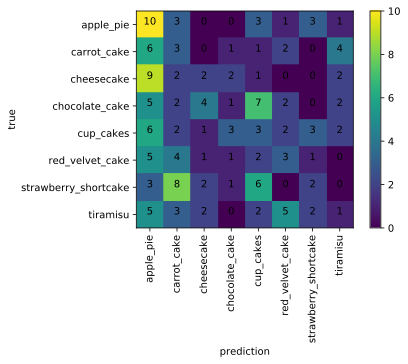

In [17]:
CM = metrics.confusion_matrix(testY, mypred)

plt.imshow(CM, interpolation='nearest')
plt.colorbar()

tick_marks = arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('prediction')
plt.ylabel('true')
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j,i,"{}".format(CM[i,j]), horizontalalignment='center')

### How does the classifier make errors?

- The above confusion matrix is computed based on the prediction of the RF classifier;
- The classifier has poor prediction accuracy (around 0.2);
- The label 'apple_pie' and 'strawberry_shortcake' have more correct predictions;
- The classifier makes more error on 'red_velvet_cake', 'carrot_cake', and 'tiramisu'.

## 5. Transfer learning

Try using a pre-trained network as the backbone for a new network. You can try some of the following:
- training an MLP classifier using the 2048 features from ResNet.
- using other networks (e.g., InceptionNet) to extract the features.
  - remember to change the pre-processing step too.
- using the a feature map (7x7x2048) and applying a small CNN.
- fine-tuning the whole network.

In [18]:
### INSERT YOUR CODE HERE ####

In [19]:
# generate a fixed validation set from the training set
vtrainXf, validXf, vtrainY, validY = model_selection.train_test_split(trainXf, trainYb, 
                                         train_size=0.9, test_size=0.1, random_state=6487)

# validation data
validset=(validXf, validY)

### Data augmentation

In [21]:
def add_gauss_noise(X, sigma2=0.1):  #0.05
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True, 
    preprocessing_function=add_gauss_noise, 
)

### 2 - MLP classifier

In [23]:
# setup early stopping callback function
earlystop = keras.callbacks.EarlyStopping(
    monitor='accuracy',     # look at the validation loss
    min_delta=0.00001,       # threshold to consider as no change
    patience=5,             # stop if 5 epochs with no change
    verbose=1, mode='auto'
)
callbacks_list = [earlystop]

In [24]:
# Network: a 4-layer-MLP, 2048->512->256->8

K.clear_session()

nn = Sequential()
nn.add(Flatten(input_shape=(2048,1)))         # input layer flatterning
nn.add(Dense(units=512, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, activation='relu')) # hidden layer 2
nn.add(Dense(units=64, activation='relu')) # hidden layer 3
nn.add(Dense(units=8, activation='softmax')) # output layer

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.001, momentum=0, nesterov=False),
           metrics=['accuracy'])

history = nn.fit(vtrainXf, vtrainY, epochs=100, batch_size=64,
                 callbacks=callbacks_list,validation_data=validset, verbose=True)

predY = nn.predict(testXf)
predY = np.argmax(predY,axis=1)
acc = metrics.accuracy_score(testY, predY) 
print("test accuracy:", acc)
print(testY)
print(predY)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/9 [==>...........................] - ETA: 2s - loss: 2.2071 - accuracy: 0.1562WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f7eb25d59e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9/9 [==============================] - 1s 26ms/step - loss: 2.1624 - accuracy: 0.1215 - val_loss: 2.0651 - val_accuracy: 0.1719
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 2.1094 - accuracy: 0.1198 - val_loss: 2.0610 - val_accuracy: 0.1562
Epoch 3/100
9/9 [==============================] - 0s 9ms/step - loss: 2.0918 - accuracy: 0.1285 - val_loss: 2.0639 - val_accuracy: 0.1562
Epoch 4/100
9/9 [==============================] - 0s 11ms/step - loss: 2.0841 - accuracy: 0.1024 - val_loss: 2.0700 - val_accuracy: 0.1406
Epoch 5/100
9/9 [==============================] - 0s 12ms/step - loss: 2.0813 - accuracy: 0.1337 - val_loss: 2.0706 - val_accuracy: 0.1562
Epo

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
test accuracy: 0.11875
[3 6 3 7 3 0 6 4 1 3 3 1 3 4 4 5 3 3 7 1 4 2 2 1 3 4 5 0 6 3 3 6 3 0 3 6 0
 7 4 5 6 6 0 0 4 4 4 0 0 7 5 0 7 4 2 6 7 5 4 2 3 2 6 5 1 2 2 6 6 5 7 6 0 0
 3 3 3 4 4 4 6 0 3 1 6 0 7 4 1 0 3 4 2 0 7 5 4 7 2 7 3 0 7 2 4 6 5 0 7 6 3
 5 5 4 2 0 7 2 4 2 1 0 5 6 2 2 1 1 3 2 2 6 0 5 7 5 1 3 6 1 7 2 5 4 1 1 7 6
 0 5 7 6 7 1 7 5 6 1 4 1]
[1 2 5 2 5 1 1 1 1 5 1 1 5 1 1 2 1 1 1 2 2 1 5 2 3 1 2 1 5 3 2 2 5 1 3 1 1
 5 1 1 1 5 1 1 1 2 1 1 1 1 5 1 5 1 1 1 5 1 2 1 1 1 1 1 1 1 1 1 5 1 1 1 5 5
 5 1 1 1 1 2 1 1 2 1 2 3 2 1 1 1 1 6 5 1 1 1 1 1 1 3 1 1 1 1 5 5 1 1 1 1 1
 1 1 1 5 1 1 1 5 2 1 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 5 2 1
 2 5 2 2 1 2 1 1 5 1 1 2]


### 3 - CNN classifier with data augmentation

In [26]:
# generate a fixed validation set using 10% of the training set
vtrainXim, validXim, vtrainYb, validYb = \
  model_selection.train_test_split(trainXim, trainYb, 
  train_size=0.9, test_size=0.1, random_state=6487)

# validation data
validset  = (validXim, validYb)
datagen.fit(vtrainXim)

In [29]:
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# create the base pre-trained model with-out the classifier
base_model = resnet.ResNet50(weights='imagenet', include_top=False, pooling='avg')
x = base_model.output

x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# finally, the softmax for the classifier (2 classes)
predictions = Dense(8, activation='softmax')(x)

In [30]:
# build the model for training
# - need to specify the input layer and the output layer
model_ft = Model(inputs=base_model.input, outputs=predictions)

# fix the layers of the ResNet50.
for layer in base_model.layers:
    layer.trainable = False

# compile the model - only the layers that we added will be trained
model_ft.compile(optimizer='rmsprop',  
              loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# train the model on the new data for a few epochs
bsize = 64
callbacks_list = []
history = model_ft.fit_generator(
            datagen.flow(vtrainXim, vtrainYb, batch_size=bsize),  # data from generator
            steps_per_epoch=len(vtrainXim)/bsize,    # should be number of batches per epoch
            epochs=20,
            callbacks=callbacks_list, 
            validation_data=validset, verbose=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9/9 [==============================] - ETA: 0s - loss: 2.3941 - accuracy: 0.1042WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f7e53758170> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9/9 [==============================] - 56s 6s/step - loss: 2.3941 - accuracy: 0.1042 - val_loss: 2.1263 - val_accuracy: 0.0938
Epoch 2/20
9/9 [==============================] - 55s 6s/step - loss: 2.1059 - accuracy: 0.1267 - val_loss: 2.0937 - val_accuracy: 0.1094
Epoch 3/20
9/9 [==============================] - 51s 6s/step - loss: 2.0937 - accuracy: 0.1198 - val_loss: 2.0892 - val_accuracy: 0.0781
Epoch 4/20
9/9 [==============================] - 54s 6s/step - loss: 2.0799 - accuracy: 0.1319 - val_loss: 2.0800 - val_accuracy: 0.0781
Epoch 5/20
9/9 [==============================] - 57s 6s/step - loss: 2.0919 - accuracy: 0.1372 - val_loss: 2.0798 - val_accuracy: 0.0938
Epoch 6/20

## Analysis
For your best deep learning model, visualize the result and analyze the errors.

In [32]:
### INSERT YOUR CODE HERE ###

### Confusion matrux

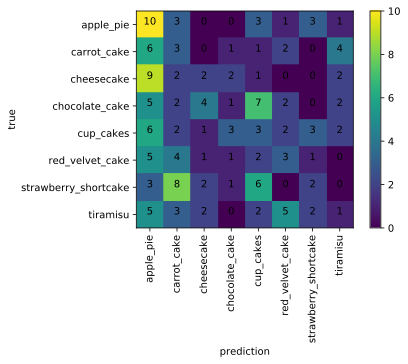

In [33]:
CM = metrics.confusion_matrix(testY, mypred)

plt.imshow(CM, interpolation='nearest')
plt.colorbar()

tick_marks = arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('prediction')
plt.ylabel('true')
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j,i,"{}".format(CM[i,j]), horizontalalignment='center')

### Where you able to improve the accuracy using deep learning? Analyze the errors from your best model.

- The classierfer works well on label 'apple_pie', 'cup_cakes', 'triamisu', I think it's because these classes have clear features.

- The classierfer works poor on label 'carrot_cake', 'cheese_cake', 'red_velvet_cake', 'strawberry_shortcake', maybe they have same color that confuses the classifier.

- The data augmentation help the classifier to improve accuracy.